# Demo Script for Milestone 10.15

## 0 Prepare task

### 0.1 prepare planning scene

#### Run camera server on the camera computer (192.168.0.10, use vnc viewer)
```bash
python stream_server.py --ip='192.168.0.10' # camera pc ip
```

#### Run shared detector on bash
```bash
python3 /home/jhkim/Projects/rnb-planning/src/scripts/milestone_202110/utils/shared_detector.py
```

#### Check and request ip setting from mobile udp client (robot-side)

#### 0.1.1 Set parameters and create planning scene

In [1]:
CONNECT_CAM = False
ENABLE_DETECT = False

CONNECT_INDY = False
CONNECT_MOBILE = False

VISUALIZE = False
ROS_MASTER_ON_MOBILE = False
PLANNING_MULTIPROC = True

# Tool dimensions
TOOL_DIM = [0.32, 0.08]
TOOL_OFFSET = 0.01
MARGIN = 0
TRACK_THICKNESS = 0.001

INDY_BASE_OFFSET = (0.172,0,0.439)
TOOL_NAME = "brush_face"
WALL_THICKNESS = 0.01
CLEARANCE = 0.001

IP_CUR = "192.168.0.8"# get_ip_address()
MOBILE_IP = "192.168.0.102"
INDY_IP = "192.168.0.3"
CAM_HOST = '192.168.0.10'

print("Current PC IP: {}".format(IP_CUR))
print("Mobile ROB IP: {}".format(MOBILE_IP))
print("CAM SERVER IP: {}".format(CAM_HOST))

Current PC IP: 192.168.0.8
Mobile ROB IP: 192.168.0.102
CAM SERVER IP: 192.168.0.10


In [2]:
import os
import sys
sys.path.append(os.path.join(os.path.join(os.environ["RNB_PLANNING_DIR"], 'src')))
sys.path.append(os.path.join(os.environ["RNB_PLANNING_DIR"], 'src/scripts/milestone_202110'))

from pkg.global_config import RNB_PLANNING_DIR
from pkg.utils.utils import *    
from pkg.utils.rotation_utils import *
from pkg.controller.combined_robot import *
from demo_utils.streaming import *
from demo_utils.detect_table import *
from demo_utils.area_select import *
from pkg.detector.aruco.marker_config import get_aruco_map
aruco_map = get_aruco_map()

from pkg.geometry.builder.scene_builder import SceneBuilder
from demo_utils.environment import *

from utils.streaming import *
from utils.detection_util import *

mobile_config = RobotConfig(0, RobotType.kmb, ((0,0,0), (0,0,0)),
                "{}/{}".format(MOBILE_IP, IP_CUR), 
                            specs={"dummy":not CONNECT_MOBILE})
robot_config = RobotConfig(1, RobotType.indy7, (INDY_BASE_OFFSET, (0,0,0)),
                INDY_IP, root_on="kmb0_platform", 
                           specs={"no_sdk":True})
MOBILE_NAME = mobile_config.get_indexed_name()
ROBOT_NAME = robot_config.get_indexed_name()
crob = CombinedRobot(robots_on_scene=[mobile_config, robot_config]
              , connection_list=[True, CONNECT_INDY])

s_builder = SceneBuilder(None)
SceneBuilder.autostart_roscore = not ROS_MASTER_ON_MOBILE
gscene = s_builder.create_gscene(crob)

gtems = s_builder.add_robot_geometries(color=(0,1,0,0.5), display=True, collision=True)
gscene.set_workspace_boundary(-4, 8, -7, 7, -CLEARANCE, 3, thickness=WALL_THICKNESS)


from pkg.planning.scene import PlanningScene
pscene = PlanningScene(gscene, combined_robot=crob)

ROBOT_BASE = pscene.robot_chain_dict[ROBOT_NAME]['link_names'][0]
TIP_LINK = pscene.robot_chain_dict[ROBOT_NAME]["tip_link"]
MOBILE_BASE = pscene.robot_chain_dict[MOBILE_NAME]["tip_link"]
HOLD_LINK = MOBILE_BASE

viewpoint = add_cam(gscene, tool_link=TIP_LINK)
# add_indy_tool_kiro(gscene, tool_link=TIP_LINK, face_name=TOOL_NAME, zoff=TOOL_OFFSET)

HOME_POSE = -crob.home_pose
HOME_DICT = list2dict(HOME_POSE, gscene.joint_names)

from pkg.planning.pipeline import PlanningPipeline
ppline = PlanningPipeline(pscene)

# Set planner
from pkg.planning.motion.moveit.moveit_planner import MoveitPlanner
from pkg.planning.filtering.grasp_filter import GraspChecker
mplan = MoveitPlanner(pscene, enable_dual=False, incremental_constraint_motion=True)
mplan.motion_filters = [GraspChecker(pscene)]
mplan.update_gscene()
gcheck = GraspChecker(pscene)
mplan.motion_filters = [gcheck]

from pkg.planning.task.rrt import TaskRRT
tplan = TaskRRT(pscene)
tplan.prepare()
ppline.set_motion_planner(mplan)
ppline.set_task_planner(tplan)

from pkg.ui.ui_broker import *

# start UI
ui_broker = UIBroker.instance()
ui_broker.initialize(ppline, s_builder)
ui_broker.start_server()

ui_broker.set_tables()

add_kiro_indytool_down(gscene, zoff=TOOL_OFFSET, tool_link=TIP_LINK, face_name=TOOL_NAME)

# Register binders
from pkg.planning.constraint.constraint_actor import VacuumTool, Gripper2Tool, PlacePlane, SweepFramer, WayFramer
brush_face = pscene.create_binder(bname=TOOL_NAME, gname=TOOL_NAME, _type=SweepFramer, 
                                  point=(-gscene.NAME_DICT['brush_face'].dims[0]/2-CLEARANCE,0,0), 
                                  rpy=(0,np.pi/2*1,0))

# waypoint
WP_DIMS = (0.6,0.4,WALL_THICKNESS)
gscene.create_safe(gtype=GEOTYPE.BOX, name="wayframer", link_name=HOLD_LINK,
                   dims=WP_DIMS, center=(0,0,WP_DIMS[2]/2), rpy=(0,0,0), color=(1, 0, 0, 0.5), display=True,
                   collision=False, fixed=True)
wayframer = pscene.create_binder(bname="wayframer", gname="wayframer", _type=WayFramer, 
                                 point=(0,0,-WP_DIMS[2]/2-CLEARANCE), rpy=(0,0,0))

indy = crob.robot_dict["indy1"]
kmb = crob.robot_dict["kmb0"]

connection command:
kmb0: True
indy1: False
Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Please create a subscriber to the marker
Dash is running on http://0.0.0.0:8050/

 * Serving Flask app "pkg.ui.dash_launcher" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.


#### 0.1.2 Load saved environment map

In [3]:
from demo_utils.ros_map_utils import KiroMobileMap
kmm = KiroMobileMap(MOBILE_IP, IP_CUR)
kmm.update_map()
pt_list = kmm.convert_im2scene(kmm.cost_canny, gscene, MOBILE_BASE, height=0.2)
_ = kmm.add_to_scene(gscene, pt_list, gtype=GEOTYPE.BOX, radius=kmm.resolution/2)
# plt.figure(figsize=(20, 10))
# plt.subplot(1,2,1)
# plt.imshow(kmm.cost_im)
# plt.subplot(1,2,2)
# plt.imshow(kmm.cost_canny)

 * Debug mode: off
==== UPDATE MAP FAILED ====
TIMEOUT


## 1. Detect scene

### 1.0 Wait task start queue

### 1.1 Detect bed

#### 1.1.1 Move to bed-seek pose 

In [4]:
Q_CUR = kmb.get_qcur()

VIEW_POSE = np.deg2rad([  0., 50.,  -70.,  -0.,  -90., 0])
VIEW_LOC = list(Q_CUR[:6])
VIEW_POSE_EXT = np.array(VIEW_LOC + list(VIEW_POSE))
if CONNECT_INDY:
    with indy:
        indy.joint_move_to(np.rad2deg(VIEW_POSE))
        time.sleep(0.5)
        indy.wait_for_move_finish()
        Qcur = np.deg2rad(indy.get_joint_pos())
else:
    Qcur = VIEW_POSE
gscene.show_pose(VIEW_POSE_EXT)

* **[TODO] rotate until bed is detected**

In [5]:
if ENABLE_DETECT:
    attacth_to_server()

In [6]:
if CONNECT_CAM:
    # rdict = send_recv_demo_cam({1:1}, host=CAM_HOST)
    rdict = stream_capture_image(ImageType.FirstView, obj_type="bed", host=CAM_HOST)
    cam_intrins, d_scale = [rdict[key] for key in ["intrins", "depth_scale"]]
    set_cam_params(cam_intrins, d_scale)
    cam_width, cam_height, cam_fx, cam_fy, cam_ppx, cam_ppy = cam_intrins
    __d_scale = d_scale
    bed_color_path = SAVE_DIR + '/bed.jpg'
    bed_depth_path = SAVE_DIR + '/bed.png'
else:
    cam_intrins = [1280, 720, 909.957763671875,  909.90283203125, 638.3824462890625, 380.0085144042969]
    d_scale = 1 / 3999.999810010204
    set_cam_params(cam_intrins, d_scale)
    cam_width, cam_height, cam_fx, cam_fy, cam_ppx, cam_ppy = cam_intrins
    __d_scale = d_scale
    bed_color_path = SAVE_DIR + '/bed.jpg'
    bed_depth_path = SAVE_DIR + '/bed.png'

In [7]:
# If bed is not detected, then pass below detection part
test = np.empty((720,1280), dtype=bool)
test[:,:] = False
det_res = False
while not det_res and ENABLE_DETECT:
    # Read color, depth image file, keep 16bit information
    color_img_read = cv2.imread(bed_color_path, flags=cv2.IMREAD_UNCHANGED)
    depth_img_read = cv2.imread(bed_depth_path, flags=cv2.IMREAD_UNCHANGED)
    
    # Output of inference(mask for detected table)
    mask_out = detect_from_server(color_img_read)
    
    res = not np.array_equal(mask_out, test)
    
    if not res and CONNECT_INDY:
        with indy:
            Qnow = indy.get_joint_pos()
            Qto = np.add(Qnow, [10,0,0,0,0,0])
            Qto[0] = (Qto[0]+np.pi/2)%np.pi-np.pi/2
            indy.joint_move_to(Qto)
            indy.wait_motion()
            VIEW_POSE_EXT[6:] = Qto
    # Take a picture again after rotate
    if CONNECT_CAM:
        time.sleep(1)
        rdict = stream_capture_image(ImageType.FirstView, obj_type="bed", host=CAM_HOST)

#### 1.1.2  detect bed and add to the scene

In [8]:
T_bc = viewpoint.get_tf(VIEW_POSE_EXT)
if ENABLE_DETECT:
    # Try ICP1
    if not np.array_equal(mask_out, test):
        plt.imshow(mask_out)

        # Crop masking part
        vis_mask = (mask_out * 255).astype('uint8')
        color_instance = cv2.bitwise_and(color_img_read, color_img_read, mask=vis_mask).astype(np.uint16)
        depth_instance = cv2.bitwise_and(depth_img_read, depth_img_read, mask=vis_mask).astype(np.uint16)
        cv2.imwrite(CROP_DIR + '/bed_crop.jpg', color_instance)
        cv2.imwrite(CROP_DIR + '/bed_crop.png', depth_instance)

        ICP_result_bed1, fitness1 = process_bed_detection_front(T_bc, visualize=False)

        # Try ICP2
    if not np.array_equal(mask_out, test):
        plt.imshow(mask_out)

        # Crop masking part
        vis_mask = (mask_out * 255).astype('uint8')
        color_instance = cv2.bitwise_and(color_img_read, color_img_read, mask=vis_mask).astype(np.uint16)
        depth_instance = cv2.bitwise_and(depth_img_read, depth_img_read, mask=vis_mask).astype(np.uint16)
        cv2.imwrite(CROP_DIR + '/bed_crop.jpg', color_instance)
        cv2.imwrite(CROP_DIR + '/bed_crop.png', depth_instance)

        ICP_result_bed2, fitness2 = process_bed_detection(visualize=False)
        
    # Better result is adopted
    if fitness1 > fitness2:
        ICP_result_bed = ICP_result_bed1
    else:
        ICP_result_bed = ICP_result_bed2        


    # Coorinate offeset
    T_toff_bed = np.identity(4)
    T_toff_bed[:3,:3] = np.array([[0,1,0],[0,0,1],[1,0,0]])
    T_toff_bed[:3,3] = np.array([0.455,0,1.02])

    T_co_bed = np.matmul(ICP_result_bed, T_toff_bed)
    T_bc = viewpoint.get_tf(list2dict(VIEW_POSE_EXT, gscene.joint_names))
    T_bo_bed = np.matmul(T_bc, T_co_bed)

    bed_center = T_bo_bed[:3,3]
    bed_rpy = Rot2rpy(T_bo_bed[:3,:3])
    # bed_center = (2,0,0)
    # bed_rpy = (0,0,np.pi/2)
    COLOR_BED_COL = (0,1,0,0.3)
    # T_revis = np.identity(4)
    # T_revis[:3,:3] = Rot_axis(3, Rot2axis(bed_vis.get_tf(VIEW_POSE_EXT)[:3,:3],3))
    # bed_rpy = Rot2rpy(Rot_axis(3, Rot2axis(bed_vis.get_tf(VIEW_POSE_EXT)[:3,:3],3)
    T_bo_new = align_z(T_bo_bed)
    bed_rpy = Rot2rpy(T_bo_new[:3,:3])

    # adjust
    bed_center[2]=0
    if Rot_rpy(bed_rpy)[0,0] > 0:
        bed_rpy[2] += np.pi

    bed_mat = add_bed(gscene, bed_center, bed_rpy, COLOR_BED_COL)
    
else:
    T_bc = viewpoint.get_tf(list2dict(VIEW_POSE_EXT, gscene.joint_names))
    bed_center = (5.1,-0.1,0)
    bed_rpy = (0,0,np.pi)
    COLOR_BED_COL = (0,1,0,0.3)
    bed_mat = add_bed(gscene, bed_center, bed_rpy, COLOR_BED_COL)

bed_vis = gscene.NAME_DICT["bed_vis"]

### 1.2 Detect Closet

#### 1.2.0 set checker

In [9]:
wp_task, wp_hdl = add_waypoint_task(pscene, "waypoint", WP_DIMS, (0,0,0), (0,0,0), 
                                    parent="floor_ws", color=(0, 0, 1, 0.5))
ccheck = CachedCollisionCheck(gcheck, wp_task, wp_hdl, wayframer)

#### 1.2.1  move to full view position

In [10]:
bed_vis = gscene.NAME_DICT["bed_vis"]
T_bo = bed_vis.get_tf(list2dict(VIEW_POSE_EXT, gscene.joint_names))

if CONNECT_CAM:
    color_path = SAVE_DIR + '/bed.jpg'
    depth_path = SAVE_DIR + '/bed.png'
else:
    color_path = EXP_IMG_DIR + '/bed.jpg'
    depth_path = EXP_IMG_DIR + '/bed.png'

if ENABLE_DETECT:
    # Determine the location of closet
    CLOSET_LOCATION = check_location_top_table(color_path, depth_path, T_bc, T_bo, bed_dims=bed_mat.dims, 
                                               visualize=False)
    print("CLOSET on {}".format(CLOSET_LOCATION))
else:
    CLOSET_LOCATION = "LEFT"
    
if CLOSET_LOCATION == "LEFT":
    angle_ref = 150
elif CLOSET_LOCATION == "RIGHT":       
    angle_ref = -150
    
bed_dim = np.linalg.norm(bed_mat.dims)
h_fov_hf = np.arctan2(cam_intrins[0], 2*cam_intrins[2])
x_z_ratio = np.tan(h_fov_hf)
bed_dist = (bed_dim/2) / x_z_ratio * 3 
while True:
    angle_view = angle_ref + np.random.uniform(-10, 10)
    dist_view = bed_dist + np.random.uniform(-1, 1)*bed_dist/8
    Tbs = bed_mat.get_tf(VIEW_POSE_EXT)
    Tbs = np.matmul(Tbs, SE3(np.identity(3), (-bed_mat.dims[0]/2, 0,0)))
    Tsc = np.matmul(SE3(Rot_axis(3, np.deg2rad(angle_view)), (0,)*3), 
                    SE3(np.identity(3), (-dist_view, 0,0)))
    Tbc = np.matmul(Tbs, Tsc)
    Tmc = viewpoint.get_tf(VIEW_POSE_EXT, from_link=MOBILE_BASE)
    Tmc[:3,:3] = np.identity(3)
    Tbm = np.matmul(Tbc, SE3_inv(Tmc))
    full_view_ext = np.copy(VIEW_POSE_EXT)
    full_view_ext[:2] = Tbm[:2,3]
    full_view_ext[2] = Rot2axis(Tbm[:3, :3], 3)
    gscene.show_pose(full_view_ext)
    ccheck.clear()
    res = ccheck(T_loal=Tbm, Q_dict=list2dict(full_view_ext, gscene.joint_names))
    if res:
        VIEW_MOVED_EXT = full_view_ext
        break
        
kmm.set_collision(False)

#### move to full view position

In [11]:
VIEW_MOVED = np.deg2rad([  0., 50.,  -70.,  -0.,  -80., 0])
# VIEW_MOVED = np.deg2rad([  0., -10.,  -0.,  -0.,  -100., 0])
if CONNECT_INDY:
    with indy:
        indy.joint_move_to(np.rad2deg(VIEW_MOVED))
    
VIEW_MOVED_EXT[crob.idx_dict[ROBOT_NAME]] = VIEW_MOVED

## [DEV] ADD SAFE WAYPOINT

In [12]:
kmb.joint_move_make_sure(VIEW_MOVED_EXT[:6])
VIEW_MOVED_EXT = crob.get_real_robot_pose()
if not CONNECT_INDY:
    VIEW_MOVED_EXT[6:] = VIEW_MOVED.copy()
gscene.show_pose(VIEW_MOVED_EXT)

#### 1.2.2 redetect bed

In [13]:
#capture image of full view
if CONNECT_CAM:
    rdict = stream_capture_image(ImageType.FullView, obj_type="full_view", host=CAM_HOST)
    
    bed_color_path = SAVE_DIR + '/full_view.jpg'
    bed_depth_path = SAVE_DIR + '/full_view.png'
    
     # Read color, depth image file, keep 16bit information
    color_img_read = cv2.imread(bed_color_path, flags=cv2.IMREAD_UNCHANGED)
    depth_img_read = cv2.imread(bed_depth_path, flags=cv2.IMREAD_UNCHANGED)
    
    # Output of inference(mask for detected table)
    mask_out = detect_from_server(color_img_read)
    
    if not np.array_equal(mask_out, test):
        plt.imshow(mask_out)

        # Crop masking part
        vis_mask = (mask_out * 255).astype('uint8')
        color_instance = cv2.bitwise_and(color_img_read, color_img_read, mask=vis_mask).astype(np.uint16)
        depth_instance = cv2.bitwise_and(depth_img_read, depth_img_read, mask=vis_mask).astype(np.uint16)
        cv2.imwrite(CROP_DIR + '/full_view.jpg', color_instance)
        cv2.imwrite(CROP_DIR + '/full_view.png', depth_instance)

if ENABLE_DETECT:
    bed_vis = gscene.NAME_DICT["bed_vis"]
    T_bc = viewpoint.get_tf(VIEW_MOVED_EXT)
    T_bs = bed_vis.get_tf(VIEW_MOVED_EXT)
    T_sc = np.matmul(SE3_inv(T_bs), T_bc)

    T_toff_bed = np.identity(4)
    T_toff_bed[:3,:3] = np.array([[0,1,0],[0,0,1],[1,0,0]])
    T_toff_bed[:3,3] = np.array([0.455,0,1.05])


    ICP_result_bed_full = reprocess_bed_detection(
        T_sc, bed_mat.dims, 0.1, T_toff_bed, visualize=False)

    T_co = np.matmul(ICP_result_bed_full, T_toff_bed)
    T_bo_bed_full = np.matmul(T_bc, T_co)

    bed_center = T_bo_bed_full[:3,3]
    bed_rpy = Rot2rpy(T_bo_bed_full[:3,:3])

    #adjust
    bed_center[2]=0
    T_bo_bed_full_new = align_z(T_bo_bed_full)
    bed_rpy = Rot2rpy(T_bo_bed_full_new[:3,:3])
    # if Rot_rpy(bed_rpy)[0,0] > 0:
    #     bed_rpy[2] += np.pi

    move_bed(gscene, bed_center, bed_rpy)

#### 1.2.3  detect and add closet

In [14]:
if ENABLE_DETECT:
    if CONNECT_CAM:
        rdict = stream_capture_image(ImageType.FirstView, obj_type="closet", host=CAM_HOST)
        closet_color_path = SAVE_DIR + '/top_table.jpg'
        closet_depth_path = SAVE_DIR + '/top_table.png'
    else:
        closet_color_path = EXP_IMG_DIR + '/top_table_0024.jpg'
        closet_depth_path = EXP_IMG_DIR + '/top_table_0024.png'

    if CONNECT_CAM:
        Qdict_scan = list2dict(VIEW_MOVED_EXT, gscene.joint_names)
    else:
        VIEW_POSE_MID = np.deg2rad([  0., 50.,  -70.,  -0.,  -75., 180])
        VIEW_MOVED_EXT[6:] = VIEW_POSE_MID
        Qdict_scan = list2dict(VIEW_MOVED_EXT, gscene.joint_names)
    T_bc = viewpoint.get_tf(Qdict_scan)
    T_bs = bed_vis.get_tf(Qdict_scan)
    T_sc = np.matmul(SE3_inv(T_bs), T_bc)

    ICP_result_top_table = process_top_table_detection(closet_color_path, closet_depth_path, T_sc=T_sc,
                                                       bed_dims=bed_mat.dims, z_ceiling = 2.3,
                                                       initial_offset=[0.3,1.1,0.6], floor_margin=0.1,
                                                       visualize=False)

    T_toff_top_table = np.identity(4)
    T_toff_top_table[:3,:3] = np.array([[1,0,0],[0,0,1],[0,-1,0]])
    T_toff_top_table[:3,3] = np.array([0.3,0,0.2725])

    T_co = np.matmul(ICP_result_top_table, T_toff_top_table)
    T_bc = viewpoint.get_tf(list2dict(VIEW_MOVED_EXT, gscene.joint_names))
    T_bo = np.matmul(T_bc, T_co)
    T_bo[:3,:3] = Rot_axis(3, Rot2axis(T_bo[:3,:3], 3))
    T_bo[2,3] = 0
else:
    T_bo = T_xyzrpy((np.matmul(Rot_rpy(bed_rpy), (-0.75,-1.5,0))+bed_center, 
                     bed_rpy))

closet_leftup, closet_rightup, closet_down = add_closet(
    gscene, closet_center=T_bo[:3,3], closet_rpy=Rot2rpy(T_bo[:3,:3]), 
    COLOR_CLOSET_COL=(0,1,0,0.3))


## 2. Closet cleaning

### 2.1. Make closet cleaning plan

In [15]:
from pkg.planning.constraint.constraint_common import *
from pkg.planning.constraint.constraint_actor import *
from pkg.planning.constraint.constraint_subject import *
from pkg.utils.code_scraps import get_look_motion

In [16]:
Q_CUR = VIEW_MOVED_EXT
HOME_POSE_SWEEP = np.copy(Q_CUR)
# HOME_POSE_SWEEP[6:] = 0
crob.home_pose = HOME_POSE_SWEEP
crob.home_dict = list2dict(crob.home_pose, gscene.joint_names)
floor_ws = gscene.NAME_DICT["floor_ws"]    

add_kiro_indytool_down(gscene, zoff=TOOL_OFFSET, tool_link=TIP_LINK, face_name=TOOL_NAME)
brush_face = pscene.create_binder(bname=TOOL_NAME, gname=TOOL_NAME, _type=SweepFramer, 
                                  point=(0,0,-gscene.NAME_DICT['brush_face'].dims[2]/2-CLEARANCE), 
                                  rpy=(0,0,0))

def make_plan_fun(surface, Q_CUR, tip_dir, tool_dir, plane_val, xout_cut=False):
    ccheck.clear()
    div_base_dict, Tsm_keys, surface_div_centers, div_num, (ax_step, ax_swp, ax_pln) = \
                            get_division_dict(surface, brush_face, robot_config, 
                                              plane_val=plane_val, tip_dir=tip_dir, TOOL_DIM=TOOL_DIM, 
                                              ccheck=ccheck, resolution=0.02, xout_cut=xout_cut)

    HOME_POSE_MOVE = np.copy(Q_CUR[6:])
    test_fun = TestBaseDivFunc(ppline, floor_ws, surface, WP_DIMS, TOOL_DIM, crob.home_dict, tool_dir=tool_dir,
                                  multiprocess=PLANNING_MULTIPROC, 
                                  timeout=0.3, timeout_loop=3)
    test_fun.clear()

    idx_bases, idc_divs, covered_all, snode_schedule_list = select_max_cover_bases(
        div_base_dict, Tsm_keys, surface_div_centers, div_num, ax_step, 
        test_fun=test_fun, lazy_base_thresh=np.max(TOOL_DIM)/2)

    snode_schedule_list, idx_bases, idc_divs, scene_args_list, scene_kwargs_list = refine_order_plan(
        ppline, snode_schedule_list, idx_bases, idc_divs, Q_CUR, 
        floor_ws, wayframer, surface, Tsm_keys, surface_div_centers,  
        WP_DIMS, TOOL_DIM, ROBOT_NAME, MOBILE_NAME, HOME_POSE_MOVE)
    test_fun.clear()
    Q_CUR = snode_schedule_list[-1][-1].state.Q
    return snode_schedule_list, scene_args_list, scene_kwargs_list, Q_CUR, test_fun

In [17]:
snode_schedule_list_leftup, scene_args_list_leftup, scene_kwargs_list_leftup, Q_CUR, test_fun= \
    make_plan_fun(closet_leftup, Q_CUR, "up", 1, plane_val=None)
snode_schedule_list_rightup, scene_args_list_rightup, scene_kwargs_list_rightup, Q_CUR, test_fun = \
    make_plan_fun(closet_rightup, Q_CUR, "up", 1, plane_val=None)
snode_schedule_list_down, scene_args_list_down, scene_kwargs_list_down, Q_CUR, test_fun = \
    make_plan_fun(closet_down, Q_CUR, "down", -1, plane_val=None)
snode_schedule_list = snode_schedule_list_leftup + snode_schedule_list_rightup + snode_schedule_list_down
scene_args_list = scene_args_list_leftup + scene_args_list_rightup + scene_args_list_down
scene_kwargs_list = scene_kwargs_list_leftup + scene_kwargs_list_rightup + scene_kwargs_list_down

terminate_on_first is deprecated. Use max_solution_count=1
Use 20/20 agents
======================= terminated 19: max iteration time reached (3/3 s) ===============================
======================= terminated 1: max iteration time reached (3/3 s) ===============================
======================= terminated 12: max iteration time reached (3/3 s) ===============================
======================= terminated 9: max iteration time reached (3/3 s) ===============================
======================= terminated 2: max iteration time reached (3/3 s) ===============================
======================= terminated 8: max iteration time reached (3/3 s) ===============================
======================= terminated 15: max iteration time reached (3/3 s) ===============================
======================= terminated 10: max iteration time reached (3/3 s) ===============================
======================= terminated 17: max iteration time reached (3/3 s) ======

======================= terminated 5: max iteration time reached (3/3 s) ===============================
======================= terminated 9: max iteration time reached (3/3 s) ===============================
======================= terminated 0: max iteration time reached (3/3 s) ===============================
======================= terminated 17: max iteration time reached (3/3 s) ===============================
======================= terminated 6: max iteration time reached (3/3 s) ===============================
======================= terminated 13: max iteration time reached (3/3 s) ===============================
======================= terminated 7: max iteration time reached (3/3 s) ===============================
======================= terminated 15: max iteration time reached (3/3 s) ===============================
======================= terminated 10: max iteration time reached (3/3 s) ===============================
======================= terminated 1: max iteration

======================= terminated 16: required answers acquired from other agent ===============================
Goal reached
======================= terminated 8: required answers acquired ===============================
Goal reached
======================= terminated 14: required answers acquired ===============================
======================= terminated 17: required answers acquired from other agent ===============================
Goal reached
======================= terminated 15: required answers acquired ===============================
======================= terminated 18: required answers acquired from other agent ===============================
Goal reached
======================= terminated 19: required answers acquired ===============================
======================= terminated 5: required answers acquired from other agent ===============================
terminate_on_first is deprecated. Use max_solution_count=1
Use 20/20 agents
Goal reached
Goal reached
====

======================= terminated 10: required answers acquired from other agent ===============================
======================= terminated 9: required answers acquired from other agent ===============================
Goal reached
======================= terminated 16: required answers acquired ===============================
Goal reached
======================= terminated 2: required answers acquired ===============================
terminate_on_first is deprecated. Use max_solution_count=1
Use 20/20 agents
Goal reached
Goal reached
======================= terminated 6: required answers acquired ===============================
======================= terminated 7: required answers acquired from other agent ===============================
Goal reached
======================= terminated 1: required answers acquired from other agent ===============================
======================= terminated 4: required answers acquired from other agent ===============================
====

======================= terminated 4: required answers acquired from other agent ===============================
======================= terminated 0: required answers acquired ===============================
======================= terminated 8: required answers acquired from other agent ===============================
======================= terminated 13: required answers acquired from other agent ===============================
======================= terminated 7: required answers acquired from other agent ===============================
======================= terminated 12: required answers acquired from other agent ===============================
Goal reached
======================= terminated 9: required answers acquired ===============================
======================= terminated 5: required answers acquired from other agent ===============================
======================= terminated 14: required answers acquired from other agent ===============================
=

======================= terminated 19: required answers acquired from other agent ===============================
======================= terminated 16: required answers acquired from other agent ===============================
======================= terminated 0: required answers acquired from other agent ===============================
======================= terminated 14: required answers acquired ===============================
======================= terminated 6: required answers acquired from other agent ===============================
======================= terminated 1: required answers acquired from other agent ===============================
======================= terminated 13: required answers acquired from other agent ===============================
======================= terminated 8: required answers acquired from other agent ===============================
======================= terminated 12: required answers acquired from other agent ===========================

Goal reached
======================= terminated 16: required answers acquired ===============================
======================= terminated 14: required answers acquired from other agent ===============================
======================= terminated 13: required answers acquired from other agent ===============================
Goal reached
======================= terminated 19: required answers acquired ===============================
Goal reached
======================= terminated 4: required answers acquired ===============================
Goal reached
======================= terminated 10: required answers acquired ===============================
Goal reached
======================= terminated 15: required answers acquired ===============================
Goal reached
======================= terminated 3: required answers acquired ===============================
Goal reached
======================= terminated 17: required answers acquired ===============================
Goal

Goal reached
======================= terminated 18: required answers acquired ===============================
Goal reached
======================= terminated 5: required answers acquired ===============================
Goal reached
======================= terminated 9: required answers acquired ===============================
Goal reached
======================= terminated 17: required answers acquired ===============================
Goal reached
======================= terminated 16: required answers acquired ===============================
Goal reached
======================= terminated 7: required answers acquired ===============================
terminate_on_first is deprecated. Use max_solution_count=1
Use 20/20 agents
Goal reached
Goal reached
======================= terminated 7: required answers acquired ===============================
======================= terminated 9: required answers acquired from other agent ===============================
Goal reached
===================

Goal reached
======================= terminated 17: required answers acquired ===============================
update 1th motion
Goal reached
update 1th motion
Goal reached
update 1th motion
Goal reached
no skip 0: 0.1199
Try mix
can skip 1: 0.0
skip success


### 2.2. Execute closet cleaning sequence

In [18]:
def adjust_base_on(Qref, closet_gtem):
    traj, succ = get_look_motion(mplan, ROBOT_NAME, Qref, 
                                 target_point=closet_gtem,
                                 com_link = pscene.robot_chain_dict[ROBOT_NAME]['link_names'][-i_lk],
                                 view_dir = [0,0,1],timeout = 1)
    traj_rev = np.array(list(reversed(traj)))
            
    if not succ:
        traj = [Qref, Qref]
        traj_rev = [Qref, Qref]

    Qref[6:] = traj[-1][6:]
    gscene.show_pose(Qref)
    if CONNECT_INDY:
        with indy: # move to look
            crob.move_joint_traj(traj, one_by_one=True)

        # test code here
        if CONNECT_CAM:
            rdict = stream_capture_image(ImageType.CloseView, obj_type="closet", host=CAM_HOST)

        if ENABLE_DETECT:
            Qdict_scan = list2dict(Qref, gscene.joint_names)
            T_bc, T_bs, T_bs_closet = \
                viewpoint.get_tf(Qdict_scan), bed_vis.get_tf(Qdict_scan), \
                gscene.NAME_DICT["closet_vis"].get_tf(Qdict_scan)
            T_sc = np.matmul(SE3_inv(T_bs), T_bc)
            T_toff_closet = np.identity(4)
            T_toff_closet[:3,:3] = np.array([[1,0,0],[0,0,1],[0,-1,0]])
            T_toff_closet[:3,3] = np.array([0.3,0,0.2725])
            T_cs_closet = np.matmul(SE3_inv(T_bc), T_bs_closet)

            ICP_result_top_table_close, pcd = reprocess_top_table_detection(
                T_sc, T_cs_closet, bed_mat.dims, T_toff_closet, visualize=False)

            T_toff_top_table = np.identity(4)
            T_toff_top_table[:3,:3] = np.array([[1,0,0],[0,0,1],[0,-1,0]])
            T_toff_top_table[:3,3] = np.array([0.3,0,0.2725])
            T_co_close = np.matmul(ICP_result_top_table_close, T_toff_top_table)
            T_bc = viewpoint.get_tf(Qdict_scan)
            T_bo_close = np.matmul(T_bc, T_co_close)

            T_bo_new = align_z(T_bo_close)

            # calculate transform based on obtained points
            pcd_center_prev = pcd.get_center()
            pcd_center_transformed_prev = np.matmul(T_bc[:3,:3], pcd_center_prev).transpose() + T_bc[:3,3]

            T_bo_p = np.identity(4)
            T_bo_p[:3,:3] = T_bo_close[:3,:3]
            T_bo_p[:3,3] = pcd_center_transformed_prev

            T_pooc = np.matmul(SE3_inv(T_bo_p), T_bo_close)
            T_bo_p[:3,:3] = Rot_axis(3, Rot2axis(T_bo_close[:3,:3], 3))
            T_bo_c_fix = np.matmul(T_bo_p, T_pooc)
            T_bo_c_fix[2,3] = 0

            # get Twoff from redetection
            Tbo0 = T_bs_closet
            Tbo1 = T_bo_c_fix

            Tbw0 = wayframer.get_tf_handle(Qdict_scan)
            Tow = np.matmul(SE3_inv(Tbo0), Tbw0)
            Tbw1 = np.matmul(Tbo1, Tow)

            Qtar = np.copy(Qref)
            Qtar[:2] = Tbw1[:2,3]
            Qtar[2] = Rot2axis(Tbw1[:3,:3], 3)

            kmb.joint_move_make_sure(Qtar[:6])
        with indy: # retrieve motion
            crob.move_joint_traj(traj_rev, one_by_one=True)
            
class SwitchState(Enum):
    NONE = 0
    BASE_MOVED = 1
    SWEEP_APPROACH = 2
    SWEEP_RETRACT = 3

class ModeSwitcherKMB:
    def __init__(self, pscene):
        self.pscene = pscene
        self.crob = pscene.combined_robot
        self.switch_delay = 0.5
        self.push_dist = 0.05

    def switch_in(self, snode_pre, snode_new):
        switch_state = SwitchState.NONE
        snode_pre = snode_pre.copy(pscene)
        snode_pre.traj = None
        from_state = snode_pre.state
        to_state = snode_new.state
        subjects, ok = pscene.get_changing_subjects(from_state, to_state)
        if len(subjects) == 2: # skip base move case - do nothing
            switch_state = SwitchState.NONE
        if len(subjects) ==0: # joint motion: quit sweep and homing - retract before motion
            switch_state = SwitchState.SWEEP_RETRACT
            Tbm = gscene.get_tf(MOBILE_BASE, from_state.Q)
            Tbm2 = np.matmul(Tbm, SE3(np.identity(3), (-self.push_dist, 0, 0)))
            Qto = np.copy(from_state.Q[:6])
            Qto[:2] = Tbm2[:2,3]
            kmb.joint_move_make_sure(Qto)
        elif subjects[0] == "sweep": # sweep approach or sweeping
            i_swp = pscene.subject_name_list.index("sweep")
            if snode_pre.state.node[i_swp] == 0: # sweep approach - move forward after motoin
                switch_state = SwitchState.SWEEP_APPROACH
            else: # sweeping
                switch_state = SwitchState.NONE
        elif subjects[0] == "waypoints":
            switch_state = SwitchState.BASE_MOVED
        return switch_state

    def switch_out(self, switch_state, snode_new):
        if switch_state == SwitchState.BASE_MOVED:
            kmb = self.crob.robot_dict['kbm0']
            adjust_base_on(snode_new.state.Q, closet_leftup)
        elif switch_state == SwitchState.SWEEP_APPROACH: # move forward
            Tbm = gscene.get_tf(MOBILE_BASE, from_state.Q)
            Tbm2 = np.matmul(Tbm, SE3(np.identity(3), (self.push_dist, 0, 0)))
            Qto = np.copy(from_state.Q[:6])
            Qto[:2] = Tbm2[:2,3]
            kmb.joint_move_make_sure(Qto)
mode_switcher=ModeSwitcherKMB(pscene)

In [19]:
D_APPROACH = 0.4
VEL_LEVEL = 3

if CONNECT_INDY:
    with indy:
        vel_level_bak = indy.get_joint_vel_level()
        print("vel_level_bak: {}".format(vel_level_bak))

    with indy:
        indy.set_joint_vel_level(VEL_LEVEL)

In [20]:
swp_fin_list = []

for i_s, (snode_schedule, sargs, skwargs) in enumerate(zip(snode_schedule_list, scene_args_list, scene_kwargs_list)):
    print("motions: {}".format(len(snode_schedule[:-1])-1))
    set_base_sweep(*sargs, **skwargs)
    if CONNECT_INDY and CONNECT_MOBILE:
        ppline.execute_schedule(snode_schedule, one_by_one=True, 
                                mode_switcher=mode_switcher)
    else:
        ppline.play_schedule(snode_schedule)
        
    # leave highlight on cleared area
    swp_fin = gscene.copy_from(gscene.NAME_DICT["sweep"], new_name="sweep_fin_{}".format(i_s), color=(0,0,1,0.5))
    swp_fin.dims = (swp_fin.dims[0], swp_fin.dims[1], swp_fin.dims[2]+0.002)
    gscene.update_marker(swp_fin)
    swp_fin_list.append(swp_fin)


motions: 2
(0, 0)->(0, 1)
(0, 1)->(1, 1)
(1, 1)->(2, 1)
motions: 2
(0, 0)->(1, 1)
(1, 1)->(2, 1)
(2, 1)->(2, 1)
motions: 3
(0, 0)->(0, 1)
(0, 1)->(1, 1)
(1, 1)->(2, 1)
(2, 1)->(2, 1)
motions: 3
(0, 0)->(0, 1)
(0, 1)->(1, 1)
(1, 1)->(2, 1)
(2, 1)->(2, 1)
motions: 3
(0, 0)->(0, 1)
(0, 1)->(1, 1)
(1, 1)->(2, 1)
(2, 1)->(2, 1)
motions: 3
(0, 0)->(0, 1)
(0, 1)->(1, 1)
(1, 1)->(2, 1)
(2, 1)->(2, 1)
motions: 2
(0, 0)->(0, 1)
(0, 1)->(1, 1)
(1, 1)->(2, 1)
motions: 2
(0, 0)->(1, 1)
(1, 1)->(2, 1)
(2, 1)->(2, 1)


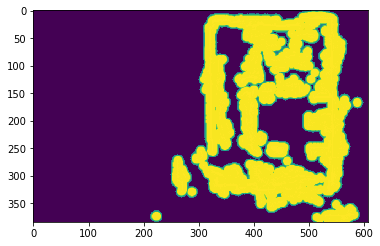

In [35]:
plt.imshow(kmm.cost_im)

### 2.3. Clear highlight

In [23]:
test_fun.clear()
for swp_fin in swp_fin_list:
    gscene.remove(swp_fin)
swp_fin_list = []
pscene.remove_subject(pscene.subject_dict["sweep"])
for child in copy.copy(closet_leftup.children):
    gscene.remove(gscene.NAME_DICT[child])
for child in copy.copy(closet_rightup.children):
    gscene.remove(gscene.NAME_DICT[child])
for child in copy.copy(closet_down.children):
    gscene.remove(gscene.NAME_DICT[child])

## 3. Bed cleaning

### 3.1 Make bed cleaning plan

#### 3.1.1 make plan

In [24]:
from pkg.planning.constraint.constraint_common import *
from pkg.planning.constraint.constraint_actor import *
from pkg.planning.constraint.constraint_subject import *

BED_OFFSET = 0.1
brush_face = pscene.create_binder(bname=TOOL_NAME, gname=TOOL_NAME, _type=SweepFramer, 
                                  point=(0,0,-gscene.NAME_DICT['brush_face'].dims[2]/2-CLEARANCE-BED_OFFSET), 
                                  rpy=(0,0,0))

T_e_brush = brush_face.get_tf_handle(crob.home_dict, from_link=TIP_LINK)
T_brush_e = SE3_inv(T_e_brush)
EE_HEIGHT = round(bed_mat.get_tf(HOME_DICT)[2,3] + bed_mat.dims[2]/2, 5) \
                + T_brush_e[2, 3] - INDY_BASE_OFFSET[2]

snode_schedule_list, scene_args_list, scene_kwargs_list, Q_CUR, test_fun = \
    make_plan_fun(bed_mat, Q_CUR, "front", 1, EE_HEIGHT, xout_cut=True)

('Height Reference: ', 0.6620000193119049)
terminate_on_first is deprecated. Use max_solution_count=1
Use 20/20 agents
Goal reached
Goal reached
======================= terminated 18: required answers acquired from other agent ===============================
======================= terminated 2: required answers acquired ===============================
Goal reached
======================= terminated 13: required answers acquired ===============================
======================= terminated 5: required answers acquired from other agent ===============================
Goal reached
======================= terminated 15: required answers acquired ===============================
Goal reached
======================= terminated 1: required answers acquired from other agent ===============================
======================= terminated 14: required answers acquired ===============================
======================= terminated 0: required answers acquired from other agent ========

======================= terminated 3: required answers acquired from other agent ===============================
======================= terminated 13: required answers acquired from other agent ===============================
======================= terminated 2: required answers acquired from other agent ===============================
======================= terminated 10: required answers acquired from other agent ===============================
======================= terminated 4: required answers acquired from other agent ===============================
Goal reached
======================= terminated 15: required answers acquired ===============================
======================= terminated 1: required answers acquired from other agent ===============================
======================= terminated 12: required answers acquired from other agent ===============================
Goal reached
======================= terminated 17: required answers acquired ==================

======================= terminated 8: required answers acquired from other agent ===============================
======================= terminated 5: required answers acquired from other agent ===============================
Goal reached
======================= terminated 14: required answers acquired ===============================
Goal reached
======================= terminated 4: required answers acquired ===============================
Goal reached
======================= terminated 6: required answers acquired ===============================
Goal reached
======================= terminated 10: required answers acquired ===============================
Goal reached
======================= terminated 1: required answers acquired ===============================
Goal reached
======================= terminated 12: required answers acquired ===============================
Goal reached
Goal reached
======================= terminated 17: required answers acquired ==========================

======================= terminated 15: required answers acquired ===============================
Goal reached
======================= terminated 18: required answers acquired ===============================
======================= terminated 5: required answers acquired from other agent ===============================
Goal reached
======================= terminated 16: required answers acquired ===============================
Goal reached
======================= terminated 19: required answers acquired ===============================
Goal reached
======================= terminated 6: required answers acquired ===============================
terminate_on_first is deprecated. Use max_solution_count=1
Use 20/20 agents
Goal reached
Goal reached
======================= terminated 11: required answers acquired ===============================
Goal reached
======================= terminated 14: required answers acquired ===============================
======================= terminated 9: requ

======================= terminated 17: required answers acquired ===============================
terminate_on_first is deprecated. Use max_solution_count=1
Use 20/20 agents
Goal reached
Goal reached
Goal reached
======================= terminated 2: required answers acquired ===============================
======================= terminated 3: required answers acquired ===============================
======================= terminated 18: required answers acquired from other agent ===============================
======================= terminated 13: required answers acquired from other agent ===============================
======================= terminated 17: required answers acquired from other agent ===============================
Goal reached
Goal reached
======================= terminated 7: required answers acquired ===============================
======================= terminated 10: required answers acquired ===============================
======================= terminated 

Goal reached
======================= terminated 3: required answers acquired ===============================
======================= terminated 1: required answers acquired from other agent ===============================
======================= terminated 11: required answers acquired from other agent ===============================
Goal reached
======================= terminated 7: required answers acquired ===============================
Goal reached
======================= terminated 9: required answers acquired ===============================
Goal reached
======================= terminated 8: required answers acquired ===============================
Goal reached
======================= terminated 10: required answers acquired ===============================
Goal reached
======================= terminated 14: required answers acquired ===============================
Goal reached
======================= terminated 13: required answers acquired ===============================
Goal re

======================= terminated 19: required answers acquired from other agent ===============================
Goal reached
======================= terminated 3: required answers acquired from other agent ===============================
======================= terminated 15: required answers acquired ===============================
Goal reached
======================= terminated 13: required answers acquired ===============================
Goal reached
======================= terminated 16: required answers acquired ===============================
======================= terminated 10: required answers acquired from other agent ===============================
Goal reached
======================= terminated 17: required answers acquired ===============================
Goal reached
======================= terminated 2: required answers acquired ===============================
Goal reached
======================= terminated 18: required answers acquired ===============================


### 3.3 Execute bed cleaning sequence

In [25]:
swp_fin_list = []

for i_s, (snode_schedule, sargs, skwargs) in enumerate(zip(snode_schedule_list, scene_args_list, scene_kwargs_list)):
    print("motions: {}".format(len(snode_schedule[:-1])-1))
    set_base_sweep(*sargs, **skwargs)
    if CONNECT_INDY and CONNECT_MOBILE:
        ppline.execute_schedule(snode_schedule, one_by_one=True, 
                                mode_switcher=mode_switcher)
    else:
        ppline.play_schedule(snode_schedule)
        
    # leave highlight on cleared area
    swp_fin = gscene.copy_from(gscene.NAME_DICT["sweep"], new_name="sweep_fin_{}".format(i_s), color=(0,0,1,0.5))
    swp_fin.dims = (swp_fin.dims[0], swp_fin.dims[1], swp_fin.dims[2]+0.002)
    gscene.update_marker(swp_fin)
    swp_fin_list.append(swp_fin)


motions: 3
(0, 0)->(0, 1)
(0, 1)->(1, 1)
(1, 1)->(2, 1)
(2, 1)->(2, 1)
motions: 3
(0, 0)->(0, 1)
(0, 1)->(1, 1)
(1, 1)->(2, 1)
(2, 1)->(2, 1)
motions: 3
(0, 0)->(0, 1)
(0, 1)->(1, 1)
(1, 1)->(2, 1)
(2, 1)->(2, 1)
motions: 3
(0, 0)->(0, 1)
(0, 1)->(1, 1)
(1, 1)->(2, 1)
(2, 1)->(2, 1)
motions: 3
(0, 0)->(0, 1)
(0, 1)->(1, 1)
(1, 1)->(2, 1)
(2, 1)->(2, 1)
motions: 3
(0, 0)->(0, 1)
(0, 1)->(1, 1)
(1, 1)->(2, 1)
(2, 1)->(2, 1)
motions: 2
(0, 0)->(0, 1)
(0, 1)->(1, 1)
(1, 1)->(2, 1)
motions: 2
(0, 0)->(1, 1)
(1, 1)->(2, 1)
(2, 1)->(2, 1)


### 3.4 Clear highlight

In [28]:
test_fun.clear()
for swp_fin in swp_fin_list:
    gscene.remove(swp_fin)
swp_fin_list = []
pscene.remove_subject(pscene.subject_dict["sweep"])
for child in copy.copy(bed_mat.children):
    gscene.remove(gscene.NAME_DICT[child])